In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
dtInCU = 16000.0
bigT = 10000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.4847073570486533  X= 20.0997201994404
A2=  -0.49962370647516496  X= 40.0
A2=  -0.5019378672698831  X= 16.740033480066963
A2=  -0.5018381151222431  X= 21.703563407126815
A2=  -0.501873065422044  X= 15.347950695901392
A2=  -0.5019294650803621  X= 13.257546515093031
A2=  -0.5019294650803621  X= 13.257546515093031
MU= 0.31816194102760903 MASS= 0.09999058237901089


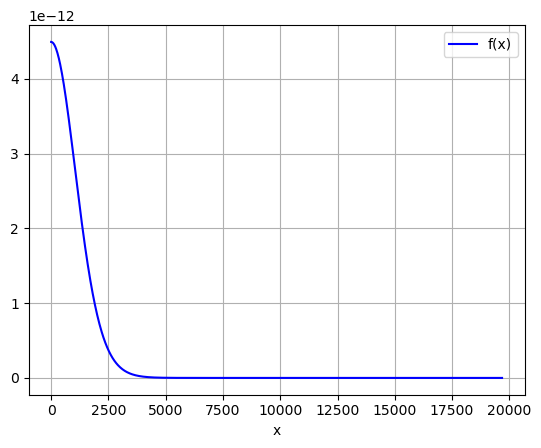

(450,)


In [2]:
allThings = outputProfile(massInCU, aInCU, totalMassInCU)
#Hot Fix
x = allThings["x"][1::2]
psi = allThings["profile"][1::2]

dx = x[1]-x[0]
for i in range(200):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
x = np.concatenate((np.flip(-x), x))

psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
psi = np.concatenate((np.flip(psi), psi))
normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
psi = psi/normalization
psi = psi.astype(complex)

'''
for index, value in enumerate(psi):
    if(value<1e-8):
        psi[index] = 0
psi = psi.astype(complex)
'''

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print(dt)

[0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+0

In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = -1.0
            T[i][i+1] = 1.0
            TSph[i][i+1] = 1.0/2.0/x[i] #What should it be?
            TSph[i][i] = -1.0/2.0/x[i]
        elif i==size-1:
            T[i][i] = -1.0
            T[i][i-1] = 1.0
            TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i] = 1.0/2.0/x[i]
        else:
            T[i][i] = -2.0
            T[i][i+1] = 1.0
            T[i][i-1] = 1.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)[size//2:]*np.absolute(psi)[size//2:]
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi)[size//2:])
    my_func.findGravRho(rho_c, phi_c, c_int(size//2), c_double(dx))
    for i in range(size//2):
        place = int(size//2 + i)
        phi[place] = phi_c[i] * GM

    for i in range(size//2):
        V2Grav[i][i] = phi[size-i-1]
        V2Grav[size-i-1][size-i-1] = phi[size-i-1]
            
        phi[i] = phi[size-i-1] #Regulate

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.05845369189663894 1.000079164309763
1 0.5344657368261458 0.05871374647022261 1.0000795113548107
2 1.0689314736522917 0.059174308993943846 1.0000801297595658
3 1.6033972104784375 0.05977788035419942 1.0000809475000216
4 2.1378629473045834 0.060535553215951464 1.000081985769944
5 2.672328684130729 0.06139706638720073 1.0000831822246048
6 3.206794420956875 0.06236942688121815 1.000084552932176
7 3.741260157783021 0.06341353150322296 1.000086048755302
8 4.275725894609167 0.06453860325845101 1.000087688371416
9 4.810191631435313 0.0657150199452042 1.0000894336526092
10 5.344657368261458 0.06681498485996606 1.000091094032506
11 5.879123105087604 0.06766289711871176 1.0000923927544971
12 6.41358884191375 0.06828360141223497 1.0000933538514392
13 6.948054578739896 0.06870184532102888 1.0000940064084722
14 7.482520315566042 0.06897159848042783 1.0000944293994802
15 8.016986052392188 0.06912355712320109 1.0000946684106884
16 8.551451789218333 0.06919564926357415 1.0000947819862323
17 9.0

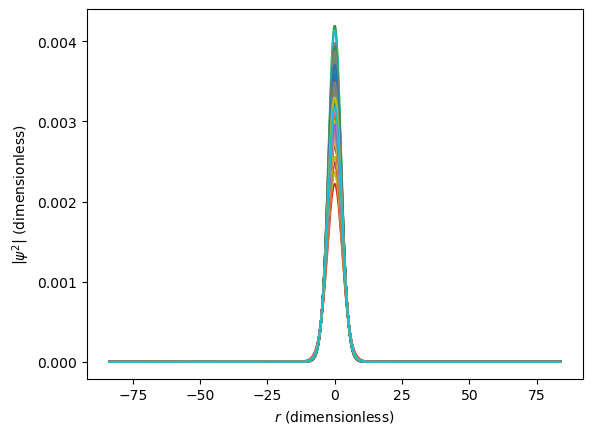

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()

hello = []
ts = []
oldGM = GM
newGM = GM*1.5
for t in range(bigT):
    #Pertubation
    if(t==0):
        GM = newGM
    if(t==10):
        GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    #Regulate
    for i in range(size//2):
        psi[i] = psi[size-i-1]

    normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
    if(normalization >= 1.01):
        break
    print(t, t*dt, np.absolute(psi[size//2]), normalization)
    if(GM == oldGM):
        hello.append(np.absolute(psi[size//2])*np.absolute(psi[size//2]))
        ts.append(t*dt)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

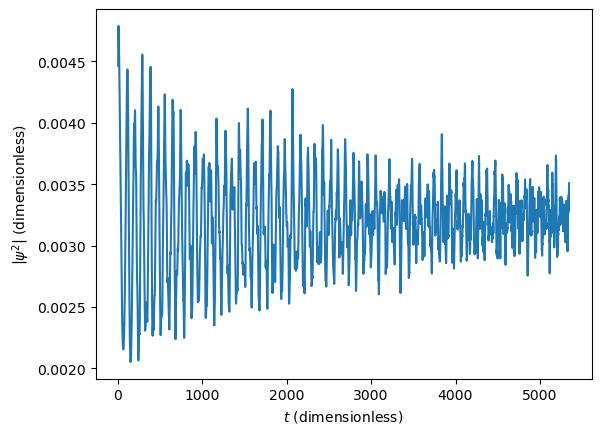

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

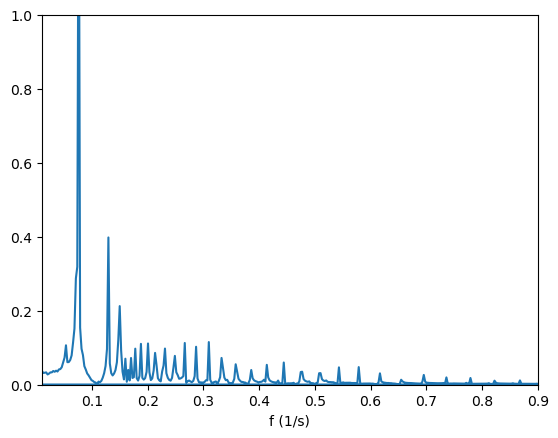

In [9]:
sp = np.fft.fft(hello[:5000])
freq = np.fft.fftfreq(len(hello[:5000]), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.9)
plt.ylim(0.0,1.0)
plt.xlabel("f (1/s)")

In [10]:
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.07 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.053291962499999984 0.10668402468441218
0.07613137499999999 1.5952414834239133
0.12942333749999999 0.39842798470517293
0.1497250375 0.21268434417571414
0.15987588749999998 0.07040013855036166
0.1700267375 0.0723325894986983
0.17763987499999997 0.09753972236161403
0.187790725 0.11060834217822067
0.2004792875 0.11161144577582663
0.21316784999999994 0.0861207553471959
0.2309318375 0.09786450236174675
0.24869582499999998 0.07803897567863478
0.26645981249999995 0.11294643330344104
0.2867615125 0.10271660162328862
0.30960092499999997 0.1153962981474305
0.33244033749999996 0.07246275943927608


[1.71542090e-05 1.72050336e-05 1.72297362e-05 1.71766709e-05
 1.69690377e-05 1.65607608e-05 1.59086859e-05 1.49907277e-05
 1.38893565e-05 1.27110707e-05 1.15778755e-05 1.06229476e-05
 9.93247030e-06 9.52225918e-06 9.32694051e-06 9.26043816e-06
 9.23794970e-06 9.12449326e-06 8.84028579e-06 8.41630088e-06
 7.89763354e-06 7.40199176e-06 7.13074021e-06 7.26111616e-06
 7.83604279e-06 8.72036386e-06 9.68817021e-06 1.04640166e-05
 1.08456261e-05 1.08335016e-05 1.05498576e-05 1.01820748e-05
 9.89186479e-06 9.72170393e-06 9.67486222e-06 9.72930523e-06
 9.79063845e-06 9.71977983e-06 9.45584459e-06 9.10673980e-06
 8.83002529e-06 8.80103735e-06 9.14607181e-06 9.88289624e-06
 1.10218561e-05 1.25348226e-05 1.43912859e-05 1.64834210e-05
 1.86929684e-05 2.09210864e-05 2.30255961e-05 2.49607513e-05
 2.66868808e-05 2.81749988e-05 2.94677512e-05 3.05612596e-05
 3.14686313e-05 3.22426670e-05 3.29171251e-05 3.35169920e-05
 3.40018407e-05 3.43070538e-05 3.44051585e-05 3.42863739e-05
 3.40362105e-05 3.374465

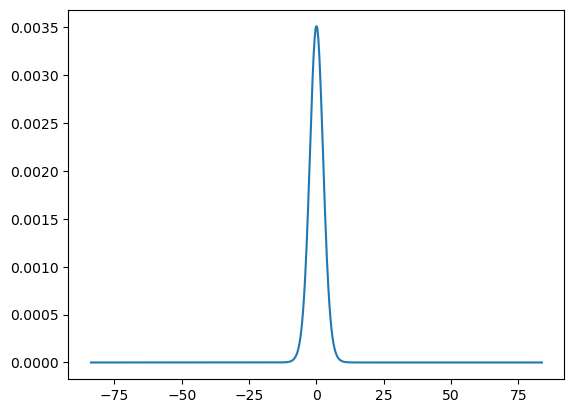

In [11]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?

In [12]:
print(psi)

[ 1.63423415e-05-5.21485963e-06j  1.63847184e-05-5.24920774e-06j
  1.63903008e-05-5.31242407e-06j  1.63096873e-05-5.38814656e-06j
  1.60653392e-05-5.46380081e-06j  1.56245434e-05-5.48930246e-06j
  1.49475581e-05-5.44580520e-06j  1.39931909e-05-5.37703685e-06j
  1.28257209e-05-5.33058232e-06j  1.15323445e-05-5.34568497e-06j
  1.02283650e-05-5.42473510e-06j  9.05314417e-06-5.55766113e-06j
  8.11009160e-06-5.73414165e-06j  7.46742190e-06-5.90855567e-06j
  7.11376582e-06-6.03209376e-06j  6.98115496e-06-6.08433976e-06j
  7.00258397e-06-6.02524128e-06j  7.05381875e-06-5.78792003e-06j
  7.02753356e-06-5.36324762e-06j  6.88109719e-06-4.84609349e-06j
  6.57813326e-06-4.37044372e-06j  6.21261765e-06-4.02403577e-06j
  5.97794473e-06-3.88736836e-06j  6.05961342e-06-4.00061159e-06j
  6.55740533e-06-4.28998858e-06j  7.38759503e-06-4.63337733e-06j
  8.37290419e-06-4.87392219e-06j  9.25557564e-06-4.88159422e-06j
  9.81082558e-06-4.62334360e-06j  1.00094334e-05-4.14439400e-06j
  9.92793938e-06-3.568685